This notebook contains code for replicating experiments from the paper "Uncertainty-Aware Deep Ensembles for Reliable and Explainable Predictions of Clinical Time Series" on ECG200 dataset. See [this webiste](http://www.timeseriesclassification.com/description.php?Dataset=ECG200) for more info on downloading the data. Remember to enable the use of GPU to speed up computations.

The following cell loads the packages used in this eexperiment, and mounts the drive. You need to change the "path" variable to the directory where the ecg data is stored in .arff format.

#Plotting time using boxplots/violinplots


## Imports

### Sktime

In [ ]:
!pip install sktime
!pip install sktime[all_extras]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.0 MB 5.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.5 MB 5.1 MB/s 
     |████████████████████████████████| 2.5 MB 40.8 MB/s 
     |████████████████████████████████| 11.2 MB 32.5 MB/s 
     |████████████████████████████████| 217 kB 60.1 MB/s 
     |████████████████████████████████| 633 kB 57.1 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 177 kB 54.0 MB/s 
     |████████████████████████████████| 6.9 MB 26.8 MB/s 
     |████████████████████████████████| 57 kB 6.0 MB/s 
     |████████████████████████████████| 1.8 MB 39.0 MB/s 
     |████████████████████████████████| 136 kB 55.6 MB/s 
     |████████████████████████████████| 793 kB 47.1 MB/s 
     |████████████████████████████████| 97 kB 2.8 MB/

In [ ]:
# Import of sktime
from sktime.classification.compose import ColumnEnsembleClassifier
from sktime.classification.dictionary_based import (
    IndividualBOSS,
    BOSSEnsemble,
    ContractableBOSS
)
from sktime.classification.hybrid import HIVECOTEV2
from sktime.classification.interval_based import DrCIF
from sktime.classification.kernel_based import RocketClassifier
from sktime.datasets import (
    load_arrow_head,
    load_basic_motions,
    load_japanese_vowels,
    load_plaid,
    load_osuleaf,
    load_from_tsfile_to_dataframe
)
from sktime.datatypes._panel._convert import (
    from_3d_numpy_to_nested,
    from_multi_index_to_3d_numpy,
    from_nested_to_3d_numpy,
    from_nested_to_2d_np_array
)

from sktime.transformations.panel.compose import ColumnConcatenator
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor

KeyboardInterrupt: ignored

### Others

In [ ]:
# Imports used in this notebook
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
import os
from matplotlib import figure
import cv2
from IPython.display import clear_output 
from re import sub
import time
import gc

from PIL import Image
import pandas as pd
import numpy as np
import seaborn as sea
import matplotlib.pyplot as plt
import datetime as dt

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, MaxPooling2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import save_img
from keras.preprocessing.image import img_to_array

sea.set_theme()


## Important Functions

In [ ]:
def camel_case(s):
  s = sub(r"(_|-)+", " ", s).title().replace(" ", "")
  return ''.join([s[0].lower(), s[1:]])

In [ ]:
def fig2data ( fig ):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGBA values
    """
    # draw the renderer
    fig.canvas.draw ( )
 
    # Get the RGBA buffer from the figure
    w,h = fig.canvas.get_width_height()
    buf = np.fromstring ( fig.canvas.tostring_rgb(), dtype=np.uint8 )
    buf.shape = ( w, h,3 )
 
    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    buf = np.roll ( buf, 3, axis = 2 )
    return buf

In [ ]:
def fig2img ( fig ):
    """
    @brief Convert a Matplotlib figure to a PIL Image in RGBA format and return it
    @param fig a matplotlib figure
    @return a Python Imaging Library ( PIL ) image
    """
    # put the figure pixmap into a numpy array
    buf = fig2data ( fig )
    w, h, d = buf.shape
    return Image.frombytes( "RGBA", ( w ,h ), buf.tostring( ) )

In [ ]:
def array2img ( array, mode = "RGB" ):
    """
    @brief Convert a Matplotlib figure to a PIL Image in RGBA format and return it
    @param fig a matplotlib figure
    @return a Python Imaging Library ( PIL ) image
    """
    # put the figure pixmap into a numpy array
    h, w, d = array.shape
    return Image.frombytes( mode, ( w, h ), array.tobytes( ) )

In [ ]:
def displayImageUniqueValues ( imageArray ):
  print("SHAPE: ", imageArray.shape, "\n")
  print("VALUES OF BACKGROUND:", imageArray[0][0], "\n")
  count = [0];
  for x in imageArray:
    for y in x:
      for value in y:
        if value not in count:
          count.append(value)

  print("UNIQUE VALUES ON DATA:", np.sort(count))

In [ ]:
def displayImageUniqueValuesMore ( imageArray ):

  print("ImageArray Shape:" , imageArray.shape)
  img2 = imageArray.reshape(-1, imageArray.shape[2]) # reshape the original image into -1, 3; -1 is placeholder, so lets say you have a 
                                                    # numpy array with shape (6,2), if you reshape it to (-1, 3), we know the second dim = 3
                                                    # first dim = (6*2)/3 = 4, so -1 is replaced with 4
  print("ImageReshape Shape:", img2.shape)

  counter = np.unique(img2, axis=0) # find unique elemenst
  '''
  numpy.unique(ar, return_index=False, return_inverse=False, return_counts=False, axis=None)[source]
  Find the unique elements of an array.

  Returns the sorted unique elements of an array. There are three optional outputs in addition to the unique elements:

  the indices of the input array that give the unique values
  the indices of the unique array that reconstruct the input array
  the number of times each unique value comes up in the input array
  '''
  #print("Array of pixels combinations:\n", counter)
  print("Shape of array", counter.shape) # as, we have separate axis, so the channels are shown in dim 2
  print("how many pixels:", counter.shape[0], "or", len(set(imageArray.flatten())))
  
  #binArray=np.bincount(counter.flatten())
  count = 0
  for value in counter:
    print("Value: ", value, "| Occurrences:", (img2 == value).sum())
    count =+ 1
  

In [ ]:
def imageConfigurations( color ):

  PROPS = {}
  rc = {}
  flierprops = dict()

  ######### Color #########
  if color:
    PROPS = {
        'boxprops':{'facecolor':'black', 'edgecolor':'red'},
        'medianprops':{'color':'green'},
        'whiskerprops':{'color':'blue'},
        'capprops':{'color':'yellow'}
    }

    rc = {
        'axes.facecolor':'black',
        'figure.facecolor':'black'
    }
    flierprops = dict(marker='o', markerfacecolor='r', markersize=1,
                      linestyle='none', markeredgecolor='r')
  ######### Black and white #########
  else:   
    PROPS= {
        'boxprops':{'facecolor':'black', 'edgecolor':'white'},
        'medianprops':{'color':'white'},
        'whiskerprops':{'color':'white'},
        'capprops':{'color':'white'}
    }

    rc = {
        'axes.facecolor':'black',
        #'axes.labelcolor':'white',
        'figure.facecolor':'black'
        
        # 'axes.spines.left.color':'white',
        # 'axes.spines.right.color':'white',
        # 'axes.spines.top.color':'white',
        # 'axes.spines.bottom.color':'white'
    }

    flierprops = dict(marker='o', markerfacecolor='w', markersize=1,
                      linestyle='none', markeredgecolor='w')
  
  return PROPS, rc, flierprops


In [ ]:
def imageConfigurationsViolin( color ):

  PROPS = {}
  rc = {}
  flierprops = dict()

  ######### Color #########
  if color:
    PROPS = {
        'bodies':{'facecolors':'red'},
        'cmeans':{'facecolors':'green'},
        'cmins':{'facecolor':'blue'},
        'cmaxes':{'edgecolor':'yellow'},
        'bodies':{'colors':'red'},
        'cbars':{'colors':'green'},
        'cmedians':{'colors':'blue'},
        'cquantiles':{'colors':'yellow'}

    }

    rc = {
        'axes.facecolor':'black',
        'axes.edgecolor':'red',
        'figure.facecolor':'black'
    }
    flierprops = dict(marker='o', markerfacecolor='r', markersize=1,
                      linestyle='none', markeredgecolor='r')
  ######### Black and white #########
  else:   
    # PROPS= {
    #     'boxprops':{'facecolor':'black', 'edgecolor':'white'},
    #     'medianprops':{'color':'white'},
    #     'whiskerprops':{'color':'white'},
    #     'capprops':{'color':'white'}
    # }

    rc = {
        'axes.facecolor':'black',
        #'axes.labelcolor':'white',
        'axes.edgecolor':'red',
        'figure.facecolor':'black'
        
        # 'axes.spines.left.color':'white',
        # 'axes.spines.right.color':'white',
        # 'axes.spines.top.color':'white',
        # 'axes.spines.bottom.color':'white'
    }

    flierprops = dict(marker='o', markerfacecolor='w', markersize=1,
                      linestyle='none', markeredgecolor='w')
  
  return PROPS, rc, flierprops

In [ ]:
def pureBlackAndWhiteImageArray ( imageArray ):
  result = imageArray
  for ir, row in enumerate(result):
    for ic, col in enumerate(row):
      for i, value in enumerate(col):
        if value < 128:
         result[ir][ic][i] = 0
        else:
         result[ir][ic][i] = 255
  return result


In [ ]:
def pureBlackAndWhiteImageArrayUpdated( imageArray, normalized = True):
  aux = imageArray != 0
  result = aux.astype("uint8")
  return result if normalized else (result*255)

### Convert dataset to boxplots 

In [ ]:
def datasetToBoxplot ( 
    dataset,
    name = "",
    isTrain = False,
    path = "",
    color = False, 
    pureBlackAndWhite = False, 
    oneInstance = False, 
    numberOfBoxplots = 10,
    grid = False,
    images = False,
    showFliers = True
  ): 

  trainOrTest = "TRAIN" if isTrain else "TEST"
  #result = np.empty((432, 288, 4), dtype=np.uint8) if oneInstance else np.empty((len(dataset), 432, 288, 4), dtype=np.uint8)
  result = np.empty((len(dataset), 432, 288, 3), dtype=np.uint8)

  for count, timeseries in enumerate(dataset):

    if oneInstance:
      timeseries = dataset

    #Create Series
    datasetSeries = pd.Series(
      timeseries, 
      index=pd.timedelta_range(
          start="00:00:00", 
          periods=timeseries.size, 
          freq="S")
      )

    #Index, testar varias variacoes. Atualmente o que controla o index eh o "numberOfBoxplots"
    #index25sec = arrowSeries.index.round('25S').strftime('%M:%S') # Usado nos tests iniciais
    # // for round number
    #indexBoxplot = datasetSeries.index.round(str(timeseries.size//numberOfBoxplots) + 'S').strftime('%M:%S')
    #indexBoxplot = pd.to_timedelta(datasetSeries.index.round(str(timeseries.size//numberOfBoxplots) + 'S').strftime('%H:%M:%S')).total_seconds().astype(int)
    
    # Foi mudado o tipo para timedelta_range para as datas nao irem para o dia
    #anterior e desformatar as horas e minutos para 23:59 por exemplo
    indexBoxplot = (datasetSeries.index
                                 .round(str(timeseries.size//numberOfBoxplots) + 'S')
                                 .total_seconds()
                                 .astype(int))

    #Configurations
    PROPS, rc, flierprops = imageConfigurations(color)
    sea.set_theme(style="ticks", rc=rc)

    figF, axF = plt.subplots(figsize=(6,4))
 
    axF.grid(grid)
    axF.tick_params(axis='x', colors='1') 
    axF.tick_params(axis='y', colors='1') 
    axF.spines['left'].set_color('1')       
    axF.spines['right'].set_color('1') 
    axF.spines['bottom'].set_color('1') 
    axF.spines['top'].set_color('1') 

    axF.tick_params(axis='x', labelsize=8)
    axF.tick_params(axis='y', labelsize=8)

    #Boxplot
    sea.boxplot(x=indexBoxplot, y=datasetSeries, ax=axF, linewidth='1', showfliers= showFliers, flierprops=flierprops, **PROPS)
    #sea.violinplot(indexBoxplot, datasetSeries, ax=axF, **PROPS)

    if images:
      ############################################# Images
      #Create and save images in directory
      # Put on stand by, because I do not have a good way to save the images
      #as I want and load them

      if not os.path.exists( path + "/" + name + "/" + trainOrTest ):
        os.makedirs( path + "/" + name + "/" + trainOrTest )

      plt.savefig( path + "/" + 
                   name + "/" + 
                   trainOrTest + "/" +
                   name + "_extra" + str(count) +  ".png")
      plt.close()
      continue
      #############################################
    else:
    
      #Save Boxplot in array
      boxplotImage = pureBlackAndWhiteImageArray(fig2data(figF)) if pureBlackAndWhite else fig2data(figF)
      # boxplotImage = boxplotImage.reshape()

      if oneInstance:
        return boxplotImage
      else:
        result[count] = boxplotImage


    plt.close()

  return result

### Convert dataset to violinplots


In [ ]:
def datasetToViolinplot ( 
    dataset,
    name = "",
    isTrain = False,
    path = "",
    color = False, 
    pureBlackAndWhite = False, 
    oneInstance = False, 
    numberOfViolinplots = 10,
    grid = False,
    images = False,
    inner = "box"
  ): 

  trainOrTest = "TRAIN" if isTrain else "TEST"
  #result = np.empty((432, 288, 4), dtype=np.uint8) if oneInstance else np.empty((len(dataset), 432, 288, 4), dtype=np.uint8)
  result = np.empty((len(dataset), 432, 288, 3), dtype=np.uint8)

  for count, timeseries in enumerate(dataset):

    if oneInstance:
      timeseries = dataset

    #Create Series
    datasetSeries = pd.Series(
      timeseries, 
      index=pd.timedelta_range(
          start="00:00:00", 
          periods=timeseries.size, 
          freq="S")
      )

    #Index, testar varias variacoes. Atualmente o que controla o index eh o "numberOfBoxplots"
    #index25sec = arrowSeries.index.round('25S').strftime('%M:%S') # Usado nos tests iniciais
    # // for round number
    #indexBoxplot = datasetSeries.index.round(str(timeseries.size//numberOfBoxplots) + 'S').strftime('%M:%S')
    #indexBoxplot = pd.to_timedelta(datasetSeries.index.round(str(timeseries.size//numberOfBoxplots) + 'S').strftime('%H:%M:%S')).total_seconds().astype(int)
    
    # Foi mudado o tipo para timedelta_range para as datas nao irem para o dia
    #anterior e desformatar as horas e minutos para 23:59 por exemplo
    indexBoxplot = (datasetSeries.index
                                 .round(str(timeseries.size//numberOfViolinplots) + 'S')
                                 .total_seconds()
                                 .astype(int))

    #Configurations
    PROPS, rc, flierprops = imageConfigurationsViolin(color)
    # PROPSB, rcB, flierpropsB = imageConfigurations(color)
    sea.set_theme(style="ticks", rc=rc)

    figF, axF = plt.subplots(figsize=(6,4))
 
    axF.grid(grid)
    axF.tick_params(axis='x', colors='1') 
    axF.tick_params(axis='y', colors='1') 
    axF.spines['left'].set_color('1')       
    axF.spines['right'].set_color('1') 
    axF.spines['bottom'].set_color('1') 
    axF.spines['top'].set_color('1') 

    axF.tick_params(axis='x', labelsize=8)
    axF.tick_params(axis='y', labelsize=8)

    #Boxplot
    sea.violinplot(x=indexBoxplot, y=datasetSeries, ax=axF, palette=['1'], 
                   flierprops=flierprops, inner=inner,
                   **PROPS)
    
    # [item.set_edgecolor('1') for item in axF.collections]
    # sea.boxplot(x=indexBoxplot, y=datasetSeries, ax=axF, linewidth='1', flierprops=flierpropsB, **PROPSB)

    #sea.violinplot(indexBoxplot, datasetSeries, ax=axF, **PROPS)

    if images:
      ############################################# Images
      #Create and save images in directory
      # Put on stand by, because I do not have a good way to save the images
      #as I want and load them

      if not os.path.exists( path + "/" + name + "/" + trainOrTest ):
        os.makedirs( path + "/" + name + "/" + trainOrTest )

      plt.savefig( path + "/" + 
                   name + "/" + 
                   trainOrTest + "/" +
                   name + "_extra" + str(count) +  ".png")
      plt.close()
      continue
      #############################################
    else:
    
      #Save Boxplot in array
      boxplotImage = pureBlackAndWhiteImageArray(fig2data(figF)) if pureBlackAndWhite else fig2data(figF)
      # boxplotImage = boxplotImage.reshape()

      if oneInstance:
        return boxplotImage
      else:
        result[count] = boxplotImage


    plt.close()

  return result

### Testing Functions

In [ ]:
def create_image_dataset(df, path, dpi, img_width=432, img_height=288, target='target', verbose=True):
    X = df.drop(columns=[target]).values
    y = df[target].values
    if not os.path.isdir(path):
        os.makedirs(path)
    for i in range(len(X)):
        image_path = os.path.join(path, str(y[i]))
        if not os.path.isdir(image_path):
            os.mkdir(image_path)
        image_path = os.path.join(image_path, str(i) + '.png')
        fig = figure.Figure(figsize=(img_width / dpi, img_height / dpi))
        ax = fig.subplots(1)
        ax.plot(X[i])
        fig.savefig(image_path, dpi=dpi)
        if verbose:
            print(f'[{i+1}/{len(X)}] image generated')

In [ ]:
def bincount2d(arr, bins=None):
    if bins is None:
        bins = np.max(arr) + 1
    count = np.zeros(shape=[len(arr), bins], dtype=np.int64)
    indexing = (np.ones_like(arr).T * np.arange(len(arr))).T
    np.add.at(count, (indexing, arr), 1)

    return count

## Data Management

### Choose Dataset

In [ ]:
from google.colab import drive
# drive.flush_and_unmount()
drive.mount('/content/drive')


Mounted at /content/drive


Datasets que faltam:
* FordB
* Fungi
* GestureMidAirD1
* GestureMidAirD2
* GestureMidAirD3
* GesturePebbleZ1
* GesturePebbleZ2
* NonInvasiveFetalECGThorax1
* NonInvasiveFetalECGThorax2
* PickupGestureWiimoteZ
* ShakeGestureWiimoteZ

In [ ]:
DATA_SET_NAMES = [
"ACSF1",
"Adiac",
"ArrowHead",
"Beef",
"BeetleFly",
"BirdChicken",
"BME",
"Car",
"CBF",
"Chinatown",
"ChlorineConcentration",
"CinCECGTorso",
"Coffee",
"Computers",
"Crop",
"DiatomSizeReduction",
"DistalPhalanxOutlineAgeGroup",
"DistalPhalanxOutlineCorrect",
"DistalPhalanxTW",
"Earthquakes",
"ECG200",
"ECG5000",
"ECGFiveDays",
"ElectricDevices",
"EthanolLevel",
"FaceAll",
"FaceFour",
"FacesUCR",
"FiftyWords",
"Fish",
"FordA",
"FordB",
"FreezerRegularTrain",
"FreezerSmallTrain",
"GunPoint",
"GunPointAgeSpan",
"GunPointMaleVersusFemale",
"GunPointOldVersusYoung",
"Ham",
"Haptics",
"Herring",
"HouseTwenty",
"InlineSkate",
"InsectEPGRegularTrain",
"InsectEPGSmallTrain",
"ItalyPowerDemand",
"LargeKitchenAppliances",
"Lightning2",
"Lightning7",
"Mallat",
"Meat",
"MedicalImages",
"MiddlePhalanxOutlineAgeGroup",
"MiddlePhalanxOutlineCorrect",
"MiddlePhalanxTW",
"MixedShapesRegularTrain",
"MixedShapesSmallTrain",
"MoteStrain",
"OliveOil",
"OSULeaf",
"PhalangesOutlinesCorrect",
"Phoneme",
"PigAirwayPressure",
"PigArtPressure",
"PigCVP",
"Plane",
"ProximalPhalanxOutlineAgeGroup",
"ProximalPhalanxOutlineCorrect",
"ProximalPhalanxTW",
"Rock",
"ScreenType",
"SemgHandGenderCh2",
"SemgHandMovementCh2",
"SemgHandSubjectCh2",
"ShapeletSim",
"ShapesAll",
"SmallKitchenAppliances",
"SmoothSubspace",
"SonyAIBORobotSurface1",
"SonyAIBORobotSurface2",
"StarLightCurves",
"Strawberry",
"SwedishLeaf",
"Symbols",
"SyntheticControl",
"ToeSegmentation1",
"ToeSegmentation2",
"Trace",
"TwoLeadECG",
"TwoPatterns",
"UMD",
"UWaveGestureLibraryAll",
"Wafer",
"Wine",
"WordSynonyms",
"Worms",
"WormsTwoClass",
"Yoga"
]

In [ ]:
#OsuLeaf = 80
dataSet = DATA_SET_NAMES[0]
print("Using: ", dataSet)

Using:  ACSF1


In [ ]:
train_x, train_y = load_from_tsfile_to_dataframe("drive/MyDrive/Tese/Univariate_ts/" + dataSet + "/" + dataSet + "_TRAIN.ts")
test_x, test_y = load_from_tsfile_to_dataframe("drive/MyDrive/Tese/Univariate_ts/" + dataSet + "/" + dataSet + "_TEST.ts")

In [ ]:
train_x = from_nested_to_2d_np_array(train_x)
test_x = from_nested_to_2d_np_array(test_x)

(100, 1460) (100,) (100, 1460) (100,)


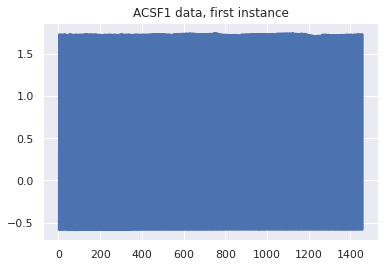

In [ ]:
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)
plt.title(dataSet + " data, first instance")
plt.plot(train_x[0])

### Boxplot and data information

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


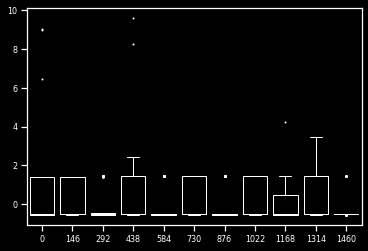

In [ ]:
boxplot = datasetToBoxplot(train_x[19], dataSet, isTrain=True,  oneInstance=True, numberOfBoxplots=10, grid=False, color=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


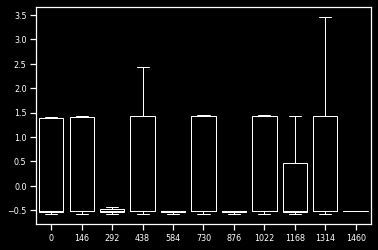

In [ ]:
boxplot = datasetToBoxplot(train_x[19], dataSet, isTrain=True,  oneInstance=True, numberOfBoxplots=10, grid=False, color=False, showFliers = False)

In [ ]:
displayImageUniqueValuesMore(boxplot)

ImageArray Shape: (432, 288, 3)
ImageReshape Shape: (124416, 3)
Shape of array (194, 3)
how many pixels: 194 or 194
Value:  [0 0 0] | Occurrences: 351921
Value:  [1 1 1] | Occurrences: 21
Value:  [2 2 2] | Occurrences: 27
Value:  [3 3 3] | Occurrences: 183
Value:  [4 4 4] | Occurrences: 63
Value:  [5 5 5] | Occurrences: 27
Value:  [6 6 6] | Occurrences: 48
Value:  [7 7 7] | Occurrences: 48
Value:  [8 8 8] | Occurrences: 6
Value:  [9 9 9] | Occurrences: 24
Value:  [10 10 10] | Occurrences: 9
Value:  [11 11 11] | Occurrences: 9
Value:  [12 12 12] | Occurrences: 15
Value:  [13 13 13] | Occurrences: 21
Value:  [14 14 14] | Occurrences: 9
Value:  [15 15 15] | Occurrences: 132
Value:  [16 16 16] | Occurrences: 30
Value:  [17 17 17] | Occurrences: 39
Value:  [18 18 18] | Occurrences: 6
Value:  [19 19 19] | Occurrences: 6
Value:  [20 20 20] | Occurrences: 3
Value:  [21 21 21] | Occurrences: 12
Value:  [22 22 22] | Occurrences: 6
Value:  [23 23 23] | Occurrences: 51
Value:  [24 24 24] | Occurre

(-0.5, 287.5, 431.5, -0.5)

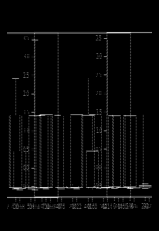

In [ ]:
image = array2img(boxplot, "RGB")
plt.imshow(image)
plt.axis('off')

### Violinplot and data information

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


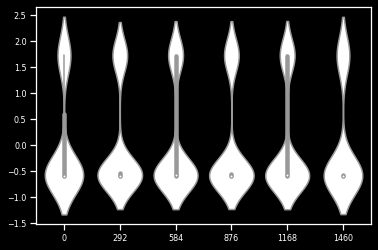

In [ ]:
violinplot = datasetToViolinplot(train_x[0], dataSet, isTrain=True,  oneInstance=True, numberOfViolinplots=5, grid=False, color=False, inner="box")

In [ ]:
displayImageUniqueValuesMore(violinplot)

ImageArray Shape: (432, 288, 3)
ImageReshape Shape: (124416, 3)
Shape of array (256, 3)
how many pixels: 256 or 256
Value:  [0 0 0] | Occurrences: 305940
Value:  [1 1 1] | Occurrences: 249
Value:  [2 2 2] | Occurrences: 180
Value:  [3 3 3] | Occurrences: 177
Value:  [4 4 4] | Occurrences: 117
Value:  [5 5 5] | Occurrences: 129
Value:  [6 6 6] | Occurrences: 90
Value:  [7 7 7] | Occurrences: 141
Value:  [8 8 8] | Occurrences: 81
Value:  [9 9 9] | Occurrences: 54
Value:  [10 10 10] | Occurrences: 72
Value:  [11 11 11] | Occurrences: 75
Value:  [12 12 12] | Occurrences: 54
Value:  [13 13 13] | Occurrences: 108
Value:  [14 14 14] | Occurrences: 60
Value:  [15 15 15] | Occurrences: 123
Value:  [16 16 16] | Occurrences: 87
Value:  [17 17 17] | Occurrences: 93
Value:  [18 18 18] | Occurrences: 30
Value:  [19 19 19] | Occurrences: 54
Value:  [20 20 20] | Occurrences: 75
Value:  [21 21 21] | Occurrences: 39
Value:  [22 22 22] | Occurrences: 87
Value:  [23 23 23] | Occurrences: 105
Value:  [24 2

(-0.5, 287.5, 431.5, -0.5)

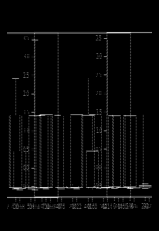

In [ ]:
image = array2img(boxplot, "RGB")
plt.imshow(image)
plt.axis('off')

### Save boxplots images/arrays

In [ ]:
# CONFIGURATIONS TO SAVE IMAGES
data = test_x
# path = "/content/drive/MyDrive/Tese/Boxplots/Imagens"
path = "/content/drive/MyDrive/Tese/Boxplots/Arrays"
name = dataSet
isTrain = True
color = False 
pureBlackAndWhite = False 
oneInstance = False 
numberOfBoxplots = 10
grid = False #Nuno disse que a grid pode fazer com que a CNN se confuda

NameError: ignored

In [ ]:
boxplot = datasetToBoxplot(data, name, isTrain, path, color, pureBlackAndWhite, oneInstance, numberOfBoxplots, grid)
clear_output()

#### Save arrays

One instance

In [ ]:
trainOrTest = "_train" if isTrain else "_test"

arrayPath = path + "/" + name + "/" + name + trainOrTest

if not os.path.exists( path + "/" + name  ):
      os.makedirs( path + "/" + name  )

np.save(arrayPath, boxplot)

Multiple datasets

In [ ]:
testSomeData = False
if(testSomeData):
  for name in DATA_SET_NAMES[12:]:
    dataSet = name
    print("Using: ", dataSet)
    train_x, train_y = load_from_tsfile_to_dataframe("drive/MyDrive/Tese/Univariate_ts/" + dataSet + "/" + dataSet + "_TRAIN.ts")
    test_x, test_y = load_from_tsfile_to_dataframe("drive/MyDrive/Tese/Univariate_ts/" + dataSet + "/" + dataSet + "_TEST.ts")
    train_x = from_nested_to_2d_np_array(train_x)
    test_x = from_nested_to_2d_np_array(test_x)

    # CONFIGURATIONS
    path = "/content/drive/MyDrive/Tese/Boxplots/Arrays/12_boxplots"
    name = dataSet
    isTrain = False
    color = False 
    pureBlackAndWhite = False 
    oneInstance = False 
    numberOfBoxplots = 12  #Test this number
    grid = False 

    # startBoxplotTrain = time.time()
    train_x = datasetToBoxplot(train_x, numberOfBoxplots = numberOfBoxplots, grid = grid)
    # endBoxplotTrain = time.time()
    clear_output()
    
    # startBoxplotTest = time.time()
    test_x = datasetToBoxplot(test_x, numberOfBoxplots = numberOfBoxplots, grid = grid)
    # endBoxplotTest = time.time()
    clear_output()

    ############# TRAIN ############# 
    arrayPath = path + "/" + name + "/" + name + "_train"

    if not os.path.exists( path + "/" + name  ):
        os.makedirs( path + "/" + name  )

    np.save(arrayPath, train_x)

    ############# TEST ############# 
    arrayPath = path + "/" + name + "/" + name + "_test"

    if not os.path.exists( path + "/" + name  ):
        os.makedirs( path + "/" + name  )

    np.save(arrayPath, test_x)

    # print("Train took: ", (endBoxplotTrain - startBoxplotTrain), " time.")
    # print("Test took: ", (endBoxplotTest - startBoxplotTest), " time.")

    ################### RESET TO IMPROVE RAM ################################
    del(dataSet)
    del(train_x, train_y)
    del(test_x, test_y)
    del(path, name, isTrain, color, pureBlackAndWhite, oneInstance, numberOfBoxplots, grid)
    del(arrayPath)
    gc.collect()
    #########################################################################

#### Save images

In [ ]:
testSomeData = True
if(testSomeData):
  
  for name in DATA_SET_NAMES[21:]:
    dataSet = name
    print("Using: ", dataSet)
    train_x, train_y = load_from_tsfile_to_dataframe("drive/MyDrive/Tese/Univariate_ts/" + dataSet + "/" + dataSet + "_TRAIN.ts")
    test_x, test_y = load_from_tsfile_to_dataframe("drive/MyDrive/Tese/Univariate_ts/" + dataSet + "/" + dataSet + "_TEST.ts")
    train_x = from_nested_to_2d_np_array(train_x)
    test_x = from_nested_to_2d_np_array(test_x)

    # CONFIGURATIONS
    data = train_x
    path = "/content/drive/MyDrive/Tese/Boxplots/Imagens/12_boxplots"
    name = None
    isTrain = False
    color = False 
    pureBlackAndWhite = False 
    oneInstance = False 
    numberOfBoxplots = 12  #Test this number
    grid = False
    images = True

    # startBoxplotTrain = time.time()
    train_x = datasetToBoxplot(train_x, 
                               name = dataSet,
                               isTrain = True, 
                               path = path,
                               numberOfBoxplots = numberOfBoxplots, 
                               grid = grid,
                               images = images)
    # endBoxplotTrain = time.time()
    # clear_output()
    
    # startBoxplotTest = time.time()
    test_x = datasetToBoxplot(test_x, 
                              name = dataSet,
                              isTrain = False, 
                              path = path,
                              numberOfBoxplots = numberOfBoxplots,
                              grid = grid,
                              images = images)
    # endBoxplotTest = time.time()
    # clear_output()

    # print("Train took: ", (endBoxplotTrain - startBoxplotTrain), " time.")
    # print("Test took: ", (endBoxplotTest - startBoxplotTest), " time.")

    ################### RESET TO IMPROVE RAM ################################
    del(dataSet)
    del(train_x, train_y)
    del(test_x, test_y)
    del(data, path, name, isTrain, color, pureBlackAndWhite, oneInstance, numberOfBoxplots, grid)
    gc.collect()
    #########################################################################

Using:  ECGFiveDays
Using:  ElectricDevices


MISSING DATASETS:


*   Crop. too big but not used in Excel
*   ECG5000: index 20 | missing test | imagens 0 - 1445



Only some data

In [ ]:
testSomeData = False
if(testSomeData):
  # NO 9:10 só falta algumas imagens de test
  for name in DATA_SET_NAMES[9:10]:
    dataSet = name
    print("Using: ", dataSet)
    test_x, test_y = load_from_tsfile_to_dataframe("drive/MyDrive/Tese/Univariate_ts/" + dataSet + "/" + dataSet + "_TEST.ts")
    test_x = from_nested_to_2d_np_array(test_x)

    # CONFIGURATIONS
    data = train_x
    path = "/content/drive/MyDrive/Tese/Boxplots/Imagens/12_boxplots"
    name = None
    isTrain = False
    color = False 
    pureBlackAndWhite = False 
    oneInstance = False 
    numberOfBoxplots = 12  #Test this number
    grid = False
    images = True
    
    # startBoxplotTest = time.time()
    test_x = datasetToBoxplot(test_x[3700:], 
                              name = dataSet,
                              isTrain = False, 
                              path = path,
                              numberOfBoxplots = numberOfBoxplots,
                              grid = grid,
                              images = images)
    # endBoxplotTest = time.time()
    # clear_output()

    # print("Train took: ", (endBoxplotTrain - startBoxplotTrain), " time.")
    # print("Test took: ", (endBoxplotTest - startBoxplotTest), " time.")

    ################### RESET TO IMPROVE RAM ################################
    del(dataSet)
    del(test_x, test_y)
    del(data, path, name, isTrain, color, pureBlackAndWhite, oneInstance, numberOfBoxplots, grid)
    gc.collect()
    #########################################################################

Using:  ChlorineConcentration


### Load boxplots images/arrays

#### Load arrays

In [ ]:
# CONFIGURATIONS TO LOAD IMAGES
path = "/content/drive/MyDrive/Tese/Boxplots/Arrays"
name = dataSet

NameError: ignored

In [ ]:
train_x = np.load(path + "/" + name + "/" + name + "_train.npy") # load
test_x = np.load(path + "/" + name + "/" + name + "_test.npy")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  if __name__ == '__main__':


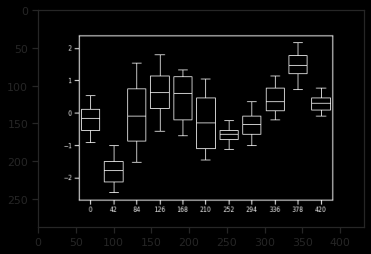

In [ ]:
image = array2img(train_x[0])

plt.imshow(image)


#### Load boxplots images


In [ ]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import imageio
import cv2

train_x = []
test_x = []

name = "Beef"

trainOrTest = 'TRAIN'
path = '/content/drive/MyDrive/Tese/Boxplots/Imagens/12_boxplots/' + name + '/' + trainOrTest + '/' + '*.png*'

for img_path in glob.glob(path):
  train_x.append(pureBlackAndWhiteImageArrayUpdated(cv2.imread(img_path), normalized = False))

trainOrTest = 'TEST'
path = '/content/drive/MyDrive/Tese/Boxplots/Imagens/12_boxplots/' + name + '/' + trainOrTest + '/' + '*.png*'

for img_path in glob.glob(path):
  test_x.append(pureBlackAndWhiteImageArrayUpdated(cv2.imread(img_path), normalized = False))

_, train_y = load_from_tsfile_to_dataframe("drive/MyDrive/Tese/Univariate_ts/" + name + "/" + name + "_TRAIN.ts")
_, test_y = load_from_tsfile_to_dataframe("drive/MyDrive/Tese/Univariate_ts/" + name + "/" + name + "_TEST.ts")

train_x = np.array(train_x)
test_x = np.array(test_x)
  #images.append(Image.open(img_path))
  # images.append(mpimg.imread(img_path, format="png")[:,:,:3].astype('uint8'))

# print("PATH: ", path, "\n Images: ", images)
# print(a.shape[1::-1])


NOTAAAAAAAAAAA: FALTA TROCAR O WIDTH COM HEIGHT em principio . (ver se melhora ou nãao faz nada)

#### Details of dataset

In [ ]:
name

'Beef'

In [ ]:
displayImageUniqueValuesMore(train_x[0])

ImageArray Shape: (288, 432, 3)
ImageReshape Shape: (124416, 3)
Shape of array (2, 3)
how many pixels: 2 or 2
Value:  [0 0 0] | Occurrences: 356187
Value:  [255 255 255] | Occurrences: 17061


CHINATOWN:

```
ImageArray Shape: (288, 432, 3)
ImageReshape Shape: (124416, 3)
Shape of array (2, 3)
how many pixels: 2 or 2
Value:  [0 0 0] | Occurrences: 356187
Value:  [1 1 1] | Occurrences: 17061
```




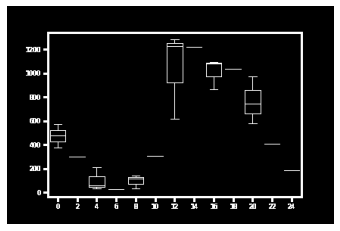

In [ ]:
image = array2img(train_x[0])
plt.axis('off')
plt.imshow(image)

TESTAR DEPOIS AGORA IGNROAR

In [ ]:
# datasetKeras = tf.keras.utils.image_dataset_from_directory("/content/drive/MyDrive/Tese/Boxplots/Imagens/" + name, image_size=(432,288))
# type(datasetKeras)
# type(datasetKeras.take(0))
# datasetKeras.take(0)
# plt.figure(figsize=(6,4))
# a = None
# for images in datasetKeras.take(1):
#   print(images)
#   a = images[0]
  # for i in range(1):
    # plt.imshow(images[i].numpy().astype("uint8"))

-----------

## Classification Test

### CNN - Plotting Time

#### Imports

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, MaxPooling2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
sea.set_theme()


In [ ]:
# [1]*10**10 INCREASE RAM, but do not work anymore

#### Prepare Data

In [ ]:
train_y = train_y.astype('uint8')
test_y = test_y.astype('uint8')

In [ ]:
print(train_y)

[1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3 4 4 4 4 4 4 5 5 5 5 5 5]


In [ ]:
while(min(train_y) > 0):
  train_y = train_y - 1
while(min(test_y) > 0):
  test_y = test_y - 1

In [ ]:
print(train_y)

[0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3 4 4 4 4 4 4]


In [ ]:
n_classes = np.unique(train_y).size

print("Number of classes: ", n_classes)
# print("Shape before one-hot encoding: ", train_y.shape)

# train_y_one_hot = np_utils.to_categorical(train_y, n_classes)
# test_y_one_hot = np_utils.to_categorical(test_y, n_classes)

# print("Shape after one-hot encoding: ", train_y_one_hot.shape)

Number of classes:  5
Shape before one-hot encoding:  (30,)
Shape after one-hot encoding:  (30, 5)


In [ ]:
train_x.shape

(30, 288, 432, 3)

In [ ]:
# NO NEED TO SINGLE CHANNEL YET MAYBE

# reshape dataset to have a single channel
# trainX = trainX[:,:,:,:1]
# testX = testX[:,:,:,:1]
width, height, channels = train_x.shape[1], train_x.shape[2], train_x.shape[3]

# train_x = train_x.reshape((train_x.shape[0], width, height, channels))
# train_x = train_x.reshape((train_x.shape[0], width, height, channels))

print("Width: ", width, "| Height: ", height, "| Channels: ", channels)

Width:  288 | Height:  432 | Channels:  3


In [ ]:
datagen = ImageDataGenerator(rescale=1.0/255.0)
# prepare an iterators to scale images
train_iterator = datagen.flow(train_x, train_y, batch_size=64) #DEPOIS SUSBTITUIR AO TRAVEZ POR TRAIN_Y e colocar no modelo aquilo que o nuno disse (ver notes)
test_iterator = datagen.flow(test_x, test_y, batch_size=64)
print('Batches train=%d, test=%d' % (len(train_iterator), len(test_iterator)))
# confirm the scaling works
batchX, batchy = train_iterator.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))


Batches train=1, test=1
Batch shape=(30, 288, 432, 3), min=0.000, max=1.000


#### Model

In [ ]:
tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph()

In [ ]:
# define model
model = Sequential()
# model.add(InputLayer(input_shape=(width, height, channels)))

model.add(Conv2D(16, (1, 1), activation='relu', input_shape=(width, height, channels)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (1, 1), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (1, 1), activation='relu'))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.7)) #Aumentar depois maybe o dropout
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(n_classes, activation='softmax'))

# early stopping
callback = EarlyStopping(monitor='loss')
# compile model
opt = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
# fit model with generator
history = model.fit(train_iterator, steps_per_epoch=len(train_iterator), epochs=500)
# history = model.fit(train_x, train_y, steps_per_epoch=len(train_iterator), epochs=100)

Epoch 1/500
1/1 [==============================] - 1s 1s/step - loss: 1.6159 - accuracy: 0.2000
Epoch 2/500
1/1 [==============================] - 0s 171ms/step - loss: 1.8302 - accuracy: 0.1333
Epoch 3/500
1/1 [==============================] - 0s 146ms/step - loss: 1.5705 - accuracy: 0.3333
Epoch 4/500
1/1 [==============================] - 0s 140ms/step - loss: 1.7318 - accuracy: 0.1667
Epoch 5/500
1/1 [==============================] - 0s 132ms/step - loss: 1.7961 - accuracy: 0.2667
Epoch 6/500
1/1 [==============================] - 0s 133ms/step - loss: 1.7148 - accuracy: 0.2667
Epoch 7/500
1/1 [==============================] - 0s 128ms/step - loss: 1.6852 - accuracy: 0.3000
Epoch 8/500
1/1 [==============================] - 0s 133ms/step - loss: 1.7434 - accuracy: 0.2333
Epoch 9/500
1/1 [==============================] - 0s 129ms/step - loss: 1.8846 - accuracy: 0.2000
Epoch 10/500
1/1 [==============================] - 0s 136ms/step - loss: 1.6271 - accuracy: 0.2667
Epoch 11/500

In [ ]:
# evaluate model
print('Test accuracy:')
_, acc = model.evaluate(test_iterator, steps=len(test_iterator))
print('Test Accuracy: %.3f' % (acc * 100))

Test accuracy:
1/1 [==============================] - 0s 238ms/step - loss: 1.2519 - accuracy: 0.5667
Test Accuracy: 56.667


#### History

dict_keys(['loss', 'accuracy'])


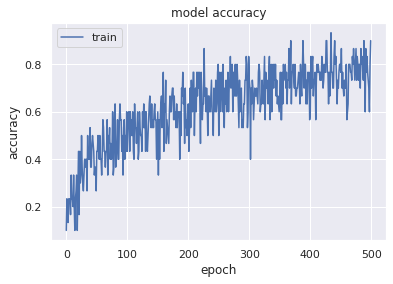

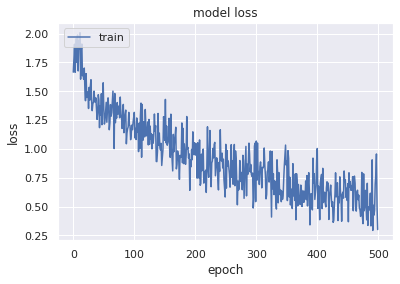

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Saved image
Greyscale image: 69.714% test accuracy

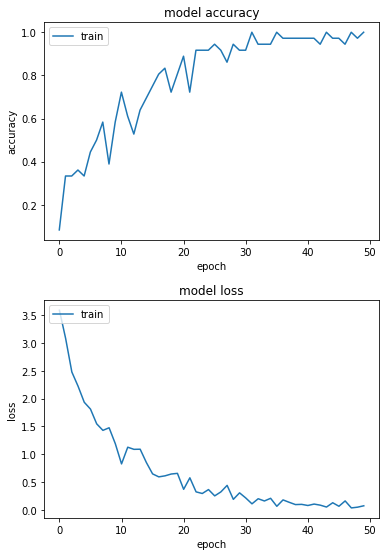

Pure black and white: 65% test accuracy

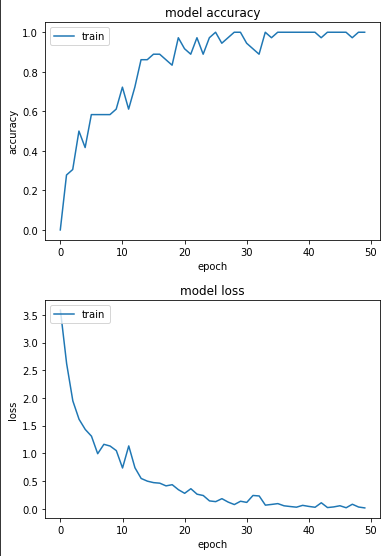

BREAK


#### TEST

-----------------------------------

In [ ]:
tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph()

O que alterei do Plotting Time:


*   Strides das Conv2D pus o default (1,1) (acho que isto já era suposto ser o default)
*   Dropout de 0.7 -> 0.5



In [ ]:
# define model
model = Sequential()
# model.add(InputLayer(input_shape=(width, height, channels)))

model.add(Conv2D(16, (1, 1), activation='relu', input_shape=(width, height, channels)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (1, 1), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (1, 1), activation='relu'))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5)) #Aumentar depois maybe o dropout
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

# early stopping
callback = EarlyStopping(monitor='loss')
# compile model
opt = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# fit model with generator
history = model.fit(train_iterator, steps_per_epoch=len(train_iterator), epochs=100)

Epoch 1/100
1/1 [==============================] - 1s 708ms/step - loss: nan - accuracy: 0.2000
Epoch 2/100
1/1 [==============================] - 0s 114ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 0s 100ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 0s 103ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 5/100
1/1 [==============================] - 0s 104ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 6/100
1/1 [==============================] - 0s 142ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 7/100
1/1 [==============================] - 0s 147ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 8/100
1/1 [==============================] - 0s 140ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 9/100
1/1 [==============================] - 0s 108ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 10/100
1/1 [==============================] - 0s 101ms/step - loss: nan - accuracy: 0.0000e+00
Epo

In [ ]:
# evaluate model
print('Test accuracy:')
_, acc = model.evaluate(test_iterator, steps=len(test_iterator))
print('Test Accuracy: %.3f' % (acc * 100))

Test accuracy:
3/3 [==============================] - 0s 88ms/step - loss: 0.6105 - accuracy: 0.7600
Test Accuracy: 76.000


dict_keys(['loss', 'accuracy'])


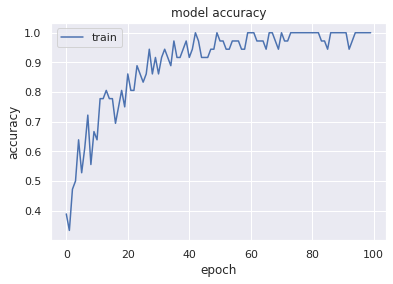

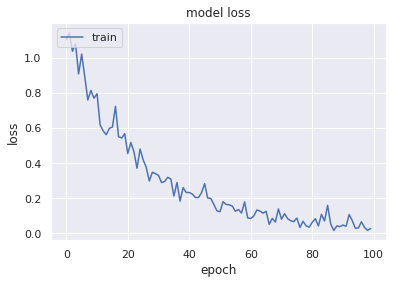

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

-------------------------------

In [ ]:
# build a sequential model
model = Sequential()
model.add(InputLayer(input_shape=(width, height, channels)))

# 1st conv block
model.add(Conv2D(25, (5, 5), activation='relu', strides=(1, 1), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
# 2nd conv block
model.add(Conv2D(50, (5, 5), activation='relu', strides=(2, 2), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization())
# 3rd conv block
model.add(Conv2D(70, (3, 3), activation='relu', strides=(2, 2), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), padding='valid'))
model.add(BatchNormalization())
# ANN block
model.add(Flatten())
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dropout(0.25))
# output layer
model.add(Dense(units=36, activation='softmax'))

# compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)
# fit on data for 30 epochs
# model.fit_generator(arrow_train_X_boxplot, epochs=30)
model.fit(
    arrow_train_X_boxplot,
    Y_train,
    epochs=10,
    validation_data=(arrow_test_X_boxplot, Y_test)
)

In [ ]:
# building a linear stack of layers with the sequential model
model = Sequential()

# convolutional layer
model.add(Conv2D(50, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(432, 288, 3)))

# convolutional layer
model.add(Conv2D(75, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(125, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# flatten output of conv
model.add(Flatten())

# hidden layer
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(36, activation='softmax'))

# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# training the model for 10 epochs
model.fit(arrow_train_X_boxplot, Y_train, batch_size=128, epochs=10, validation_data=(arrow_test_X_boxplot, Y_test))

### CNN

#### Model

In [ ]:
tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph()

NameError: ignored

In [ ]:
# define model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(width, height, channels)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))
# early stopping
callback = EarlyStopping(monitor='loss', patience=3)
# compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# fit model with generator
history = model.fit(train_iterator, steps_per_epoch=len(train_iterator), epochs=30)

NameError: ignored

In [ ]:
# evaluate model
print('Test accuracy:')
_, acc = model.evaluate(test_iterator, steps=len(test_iterator))
print('Test Accuracy: %.3f' % (acc * 100))

Test accuracy:
4/4 [==============================] - 1s 192ms/step - loss: 2.6728 - accuracy: 0.2066
Test Accuracy: 20.661


#### History

dict_keys(['loss', 'accuracy'])


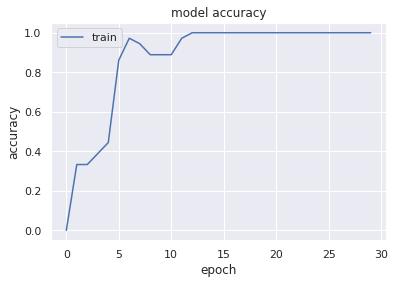

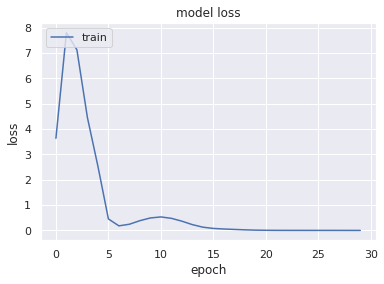

In [ ]:
sea.set_theme()
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Saved image
Greyscale image:

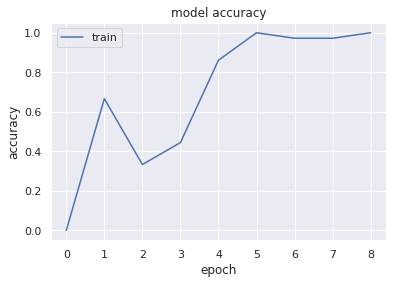
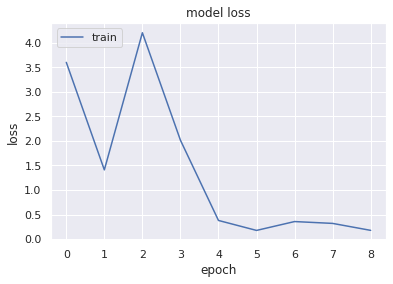

Pure black and white:

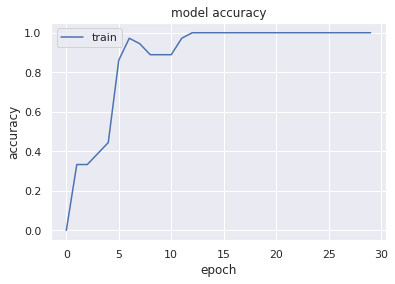
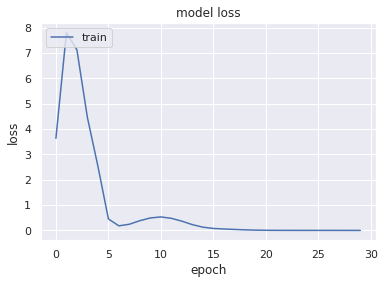

BREAK


In [ ]:
# build a sequential model
model = Sequential()
model.add(InputLayer(input_shape=(432, 288, 4)))

# 1st conv block
model.add(Conv2D(25, (5, 5), activation='relu', strides=(1, 1), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
# 2nd conv block
model.add(Conv2D(50, (5, 5), activation='relu', strides=(2, 2), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization())
# 3rd conv block
model.add(Conv2D(70, (3, 3), activation='relu', strides=(2, 2), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), padding='valid'))
model.add(BatchNormalization())
# ANN block
model.add(Flatten())
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dropout(0.25))
# output layer
model.add(Dense(units=36, activation='softmax'))

# compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)
# fit on data for 30 epochs
# model.fit_generator(arrow_train_X_boxplot, epochs=30)
model.fit(
    arrow_train_X_boxplot,
    Y_train,
    epochs=10,
    validation_data=(arrow_test_X_boxplot, Y_test)
)

Epoch 1/10


ResourceExhaustedError: ignored

In [ ]:
# building a linear stack of layers with the sequential model
model = Sequential()

# convolutional layer
model.add(Conv2D(50, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(432, 288, 3)))

# convolutional layer
model.add(Conv2D(75, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(125, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# flatten output of conv
model.add(Flatten())

# hidden layer
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(36, activation='softmax'))

# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# training the model for 10 epochs
model.fit(arrow_train_X_boxplot, Y_train, batch_size=128, epochs=10, validation_data=(arrow_test_X_boxplot, Y_test))

ResourceExhaustedError: ignored

## Some data sets from sktime


(36, 251) (36,) (175, 251) (175,)


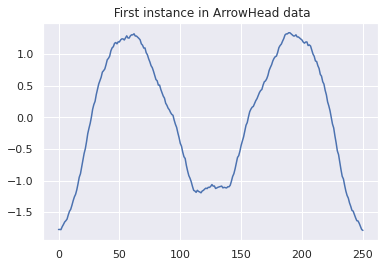

In [ ]:
# Random train set for a two class problem with 10 instances of length 50
random_train_X = np.random.rand(10, 50)
random_train_y = np.random.randint(low=0, high=2, size=10)

# Load all arrow head
arrow_X, arrow_y = load_arrow_head(return_type="numpy2d")
# Load default train/test splits from sktime/datasets/data
arrow_train_X, arrow_train_y = load_arrow_head(split="train", return_type="numpy2d")
arrow_test_X, arrow_test_y = load_arrow_head(split="test", return_type="numpyflat")
print(arrow_train_X.shape, arrow_train_y.shape, arrow_test_X.shape, arrow_test_y.shape)
plt.title(" First instance in ArrowHead data")
plt.plot(arrow_train_X[1])

In [ ]:
arrow_y

array(['0', '1', '2', '0', '1', '2', '0', '1', '2', '0', '1', '2', '0',
       '1', '2', '0', '1', '2', '0', '1', '2', '0', '1', '2', '0', '1',
       '2', '0', '1', '2', '0', '1', '2', '0', '1', '2', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2',
       '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2

<class 'numpy.ndarray'>
(40, 6, 100) (40,) (40, 6, 100) (40,)


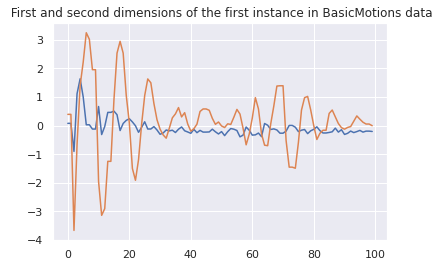

In [ ]:
# Random train set for a multivariate two class problem with 10 instances of length 50
random_train_X = np.random.rand(10, 6, 50)
random_train_y = np.random.randint(low=0, high=2, size=10)

motions_X, motions_Y = load_basic_motions(return_type="numpy3d")
motions_train_X, motions_train_y = load_basic_motions(
    split="train", return_type="numpy3d"
)
motions_test_X, motions_test_y = load_basic_motions(split="test", return_type="numpy3d")
print(type(motions_train_X))
print(
    motions_train_X.shape,
    motions_train_y.shape,
    motions_test_X.shape,
    motions_test_y.shape,
)
plt.title(" First and second dimensions of the first instance in BasicMotions data")
plt.plot(motions_train_X[0][0])
plt.plot(motions_train_X[0][1])

<class 'pandas.core.frame.DataFrame'>


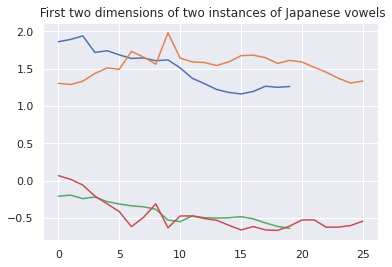

In [ ]:
# loads both train and test together
vowel_X, vowel_y = load_japanese_vowels()
print(type(vowel_X))

plt.title(" First two dimensions of two instances of Japanese vowels")
plt.plot(vowel_X.iloc[0, 0])
plt.plot(vowel_X.iloc[1, 0])
plt.plot(vowel_X.iloc[0, 1])
plt.plot(vowel_X.iloc[1, 1])
plt.show()

<class 'pandas.core.frame.DataFrame'>


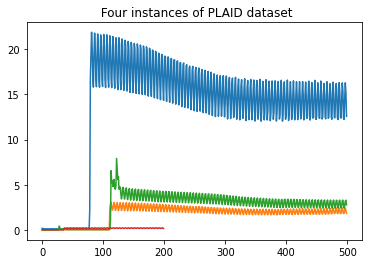

In [ ]:
plaid_X, plaid_y = load_plaid()
print(type(plaid_X))

plt.title(" Four instances of PLAID dataset")
plt.plot(plaid_X.iloc[0, 0])
plt.plot(plaid_X.iloc[1, 0])
plt.plot(plaid_X.iloc[2, 0])
plt.plot(plaid_X.iloc[3, 0])
plt.show()

## Boxplot (tests)


Int64Index([32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
            ...
            51, 51, 51, 51, 51, 51, 51, 51, 51, 51],
           dtype='int64', length=480) 

 (480,)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

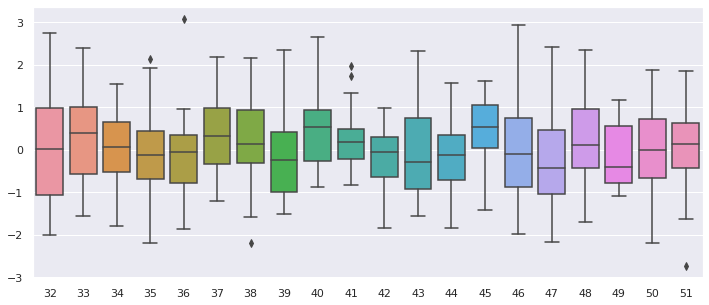

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sea
import matplotlib.pyplot as plt
import datetime as dt

sea.set_theme()

n = 480
#TEST from stackoverflow
ts = pd.Series(np.random.randn(n), index=pd.date_range(start="2014-02-01", periods=n, freq="H"))

print(ts.index.dayofyear, "\n\n", ts.shape)

fig, ax = plt.subplots(figsize=(12,5))
sea.boxplot(ts.index.dayofyear, ts, ax=ax)

In [ ]:
print(ts.index, "\n\n ", ax, "\n\n", arrow_train_X.shape)

DatetimeIndex(['2014-02-01 00:00:00', '2014-02-01 01:00:00',
               '2014-02-01 02:00:00', '2014-02-01 03:00:00',
               '2014-02-01 04:00:00', '2014-02-01 05:00:00',
               '2014-02-01 06:00:00', '2014-02-01 07:00:00',
               '2014-02-01 08:00:00', '2014-02-01 09:00:00',
               ...
               '2014-02-20 14:00:00', '2014-02-20 15:00:00',
               '2014-02-20 16:00:00', '2014-02-20 17:00:00',
               '2014-02-20 18:00:00', '2014-02-20 19:00:00',
               '2014-02-20 20:00:00', '2014-02-20 21:00:00',
               '2014-02-20 22:00:00', '2014-02-20 23:00:00'],
              dtype='datetime64[ns]', length=480, freq='H') 

  AxesSubplot(0.125,0.125;0.775x0.755) 

 (36, 251)


In [ ]:
#The function .strftime is to only get the seconds of the array index date_range
#NOTE: need to save seconds and minutes because in a minute there is only 60
# secs and we want 250 for this dataset
ts2 = pd.Series(
    arrow_train_X[0], 
    index=pd.date_range(
        start="00:00", 
        periods=arrow_train_X[0].size, 
        freq="S")
    )


In [ ]:
print(ts2.shape, "\n\n", ts2[:25])#, "\n\n\n -------------- \n", arrow_train_X[0].shape, "\n\n", arrow_train_X[0][:25])

(251,) 

 2022-03-15 00:00:00   -1.963009
2022-03-15 00:00:01   -1.957825
2022-03-15 00:00:02   -1.956145
2022-03-15 00:00:03   -1.938289
2022-03-15 00:00:04   -1.896657
2022-03-15 00:00:05   -1.869857
2022-03-15 00:00:06   -1.838705
2022-03-15 00:00:07   -1.812289
2022-03-15 00:00:08   -1.736433
2022-03-15 00:00:09   -1.673329
2022-03-15 00:00:10   -1.623073
2022-03-15 00:00:11   -1.585873
2022-03-15 00:00:12   -1.543841
2022-03-15 00:00:13   -1.456785
2022-03-15 00:00:14   -1.378721
2022-03-15 00:00:15   -1.292496
2022-03-15 00:00:16   -1.216960
2022-03-15 00:00:17   -1.108976
2022-03-15 00:00:18   -0.968688
2022-03-15 00:00:19   -0.831600
2022-03-15 00:00:20   -0.760304
2022-03-15 00:00:21   -0.599632
2022-03-15 00:00:22   -0.466256
2022-03-15 00:00:23   -0.306384
2022-03-15 00:00:24   -0.226848
Freq: S, dtype: float64


In [ ]:
#[(dt - datetime.timedelta(hours=int(dt.hour % 3))).strftime('%Y%m%d%H') for dt in ts.index]
#dataFrame = pd.DataFrame(arrow_train_X[0])

# ts2GroupBy = ts2.groupby(pd.Grouper(freq='25S'))

In [ ]:

# for name, group in ts2GroupBy:
#     print(name.freq)
#     print(group)
#     print('\n')
#     break

# ts2GroupBy.groups.keys[0]
# twentyFiveSeconds = pd.DataFrame()

# for name, group in ts2GroupBy:
#   twentyFiveSeconds[name.second] = group.values


In [ ]:
# Analisar como funciona o index do ts2, e se fizermos minute cria um array em que organiza como se fosse minuto
# a "solução" a baixo, cria um index que vai de 1 a 25 sec, multiplas vezes, mas queremos um parecido com o de cima,
#que fica aparecem 0s 25 vezes, depois 1 etc.
print(ts2.index.minute)
test = ts2.index.to_period('25S').strftime('%S')
test25sec = ts2.index.round('25S').strftime('%M:%S')
test30sec = ts2.index.round('30S').strftime('%M:%S')
test6sec = ts2.index.round('6S').strftime('%M:%S')


print(test25sec[15:])
print(test30sec[27:])

Int64Index([0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            ...
            4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
           dtype='int64', length=251)
Index(['00:25', '00:25', '00:25', '00:25', '00:25', '00:25', '00:25', '00:25',
       '00:25', '00:25',
       ...
       '04:10', '04:10', '04:10', '04:10', '04:10', '04:10', '04:10', '04:10',
       '04:10', '04:10'],
      dtype='object', length=236)
Index(['00:30', '00:30', '00:30', '00:30', '00:30', '00:30', '00:30', '00:30',
       '00:30', '00:30',
       ...
       '04:00', '04:00', '04:00', '04:00', '04:00', '04:00', '04:00', '04:00',
       '04:00', '04:00'],
      dtype='object', length=224)


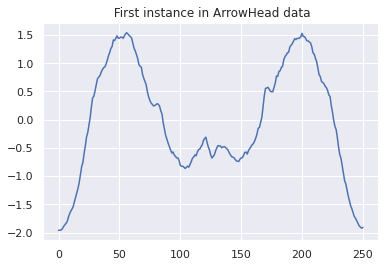

In [ ]:
plt.title(" First instance in ArrowHead data")
plt.plot(arrow_train_X[0])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

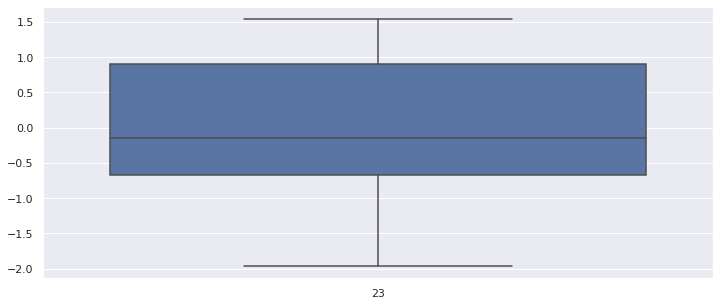

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
sea.boxplot(ts2.index.day, ts2, ax=ax) #color='black')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

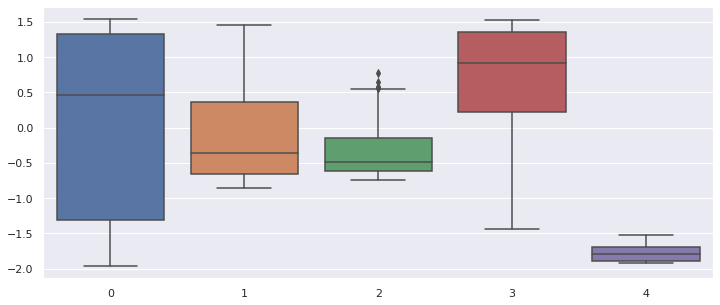

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
sea.boxplot(ts2.index.minute, ts2, ax=ax) #color='black')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

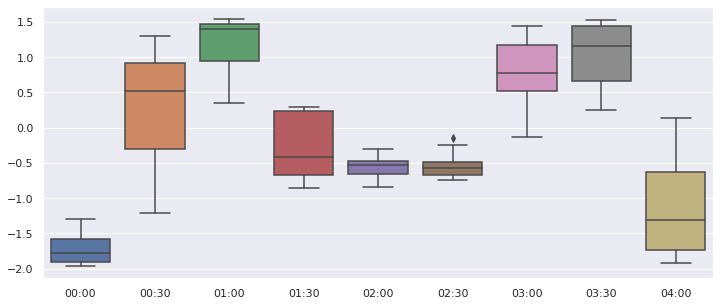

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
sea.boxplot(test30sec, ts2, ax=ax) #color='black')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

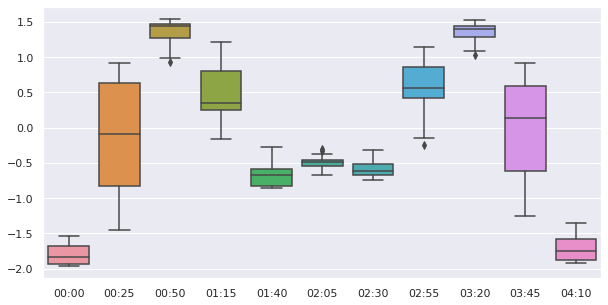

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sea.boxplot(test25sec, ts2, ax=ax) #color='black')


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

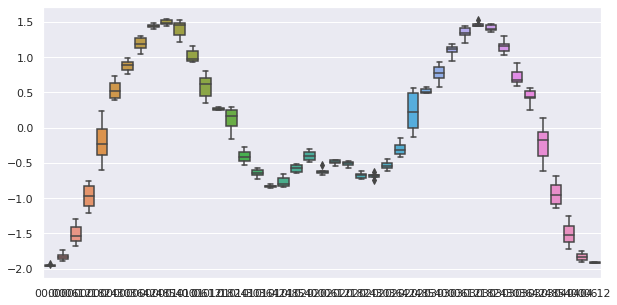

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sea.boxplot(test6sec, ts2, ax=ax) #color='black')

### Convert plot to data

Here we can see the data of the image. White corresponding to the values 255.
We will need to normalize it to be in values [0,1] and then convert the white 255=1, to negative, 0=0

In [ ]:
imageArray = fig2data(fig)
print("SHAPE: ", imageArray.shape, "\n")
print("VALUES OF BACKGROUND:", imageArray[0][0], "\n")
count = [0];
for x in imageArray:
  for y in x:
    for value in y:
      if value not in count:
        count.append(value)

print("UNIQUE VALUES ON DATA:", np.sort(count))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


SHAPE:  (720, 360, 4) 

VALUES OF BACKGROUND: [255 255 255 255] 

UNIQUE VALUES ON DATA: [  0  38  41  43  45  46  47  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  63  65  66  67  68  70  71  72  73  74  75  76  77  78
  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96
  97  98  99 100 101 102 103 105 106 107 108 109 110 111 112 113 116 117
 118 119 121 122 123 126 127 128 129 130 131 134 135 136 137 138 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 161 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 179 180 181 182 183
 184 186 187 188 189 190 191 192 193 195 196 197 200 201 202 203 204 206
 208 209 210 211 212 213 214 215 217 218 219 220 221 222 223 224 225 226
 227 228 230 232 233 234 235 236 237 238 239 242 243 244 245 246 247 248
 249 250 252 253 254 255]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  if __name__ == '__main__':


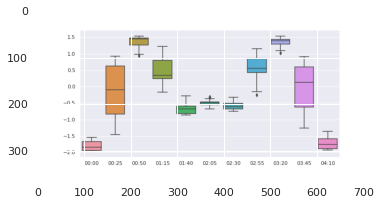

In [ ]:
image = array2img(imageArray)
plt.imshow(image)

### Improve plot representation

Removes axes for better representation of images and change style of seaborn

In [ ]:
sea.set_theme()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

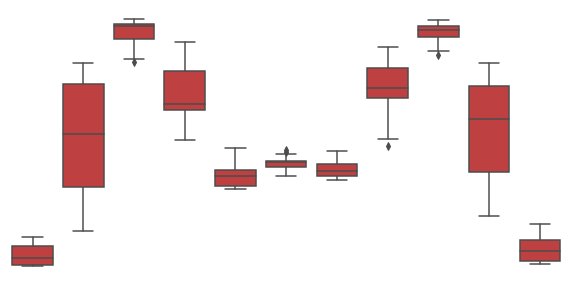

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax.axis('off')

sea.boxplot(test25sec, ts2, ax=ax, color='red', saturation=0.5)

Change line width and outliers size

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

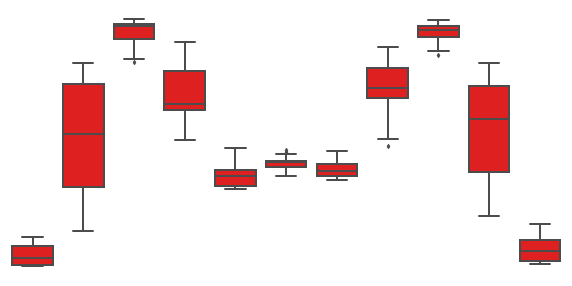

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax.axis('off')
#seaborn.set_style('darkgrid')
sea.boxplot(test25sec, ts2, ax=ax, color='red', linewidth='2', fliersize = '3')

Can also change satuaration

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

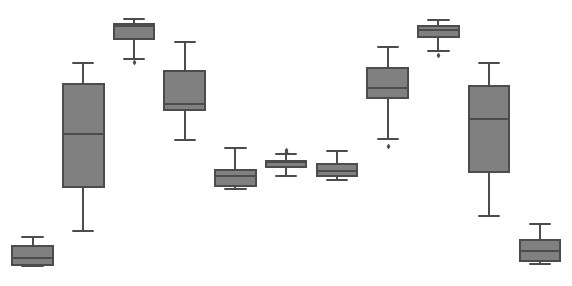

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax.axis('off')
#seaborn.set_style('darkgrid')
sea.boxplot(test25sec, ts2, ax=ax, color='red', linewidth='2', fliersize = '3', saturation=0)

Change background of seaborn (style)

In [ ]:
#sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
sea.set(rc={'figure.facecolor':'black'})
# sns.set_theme()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

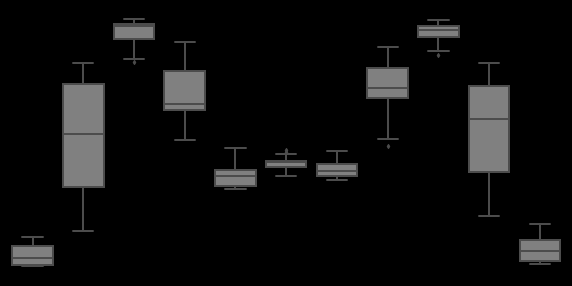

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax.axis('off')
sea.boxplot(test25sec, ts2, ax=ax, color='red', linewidth='2', fliersize = '3', saturation=0)

### Convert improved plot to data

Note: Why does Numpy's RGB array representation of an image have 4 layers not 3? 
Answer: Aplha values, transperancy

Now we can the values of the background are 0

In [ ]:
imageArray = fig2data(fig)
print("SHAPE: ", imageArray.shape, "\n")
print("VALUES OF BACKGROUND:", imageArray[0][0], "\n")
count = [0];
for x in imageArray:
  for y in x:
    for value in y:
      if value not in count:
        count.append(value)

print("UNIQUE VALUES ON DATA:", np.sort(count))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


SHAPE:  (720, 360, 4) 

VALUES OF BACKGROUND: [  0   0   0 255] 

UNIQUE VALUES ON DATA: [  0  12  13  53  60  61  68  72  74  75  76 128 255]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  if __name__ == '__main__':


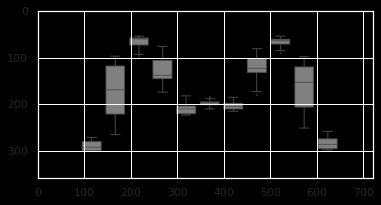

In [ ]:
image = array2img(imageArray)
plt.imshow(image)

In [ ]:
# Now we can save it to a numpy array.  cannot reshape array of size 649935 into shape (360,864,3)
# data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
# data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

## Boxplot (final representation)


Axes matter for the cnn to understand, but will test without in order to conclude this "fact". 
Also, put the image directly in grayscale
TEST the case where the different lines have different colors: 

https://stackoverflow.com/questions/43434020/black-and-white-boxplots-in-seaborn 

1- Test diferent color lines outside boxplot 

2- Test filling color of boxplot, white or black(same as background)


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sea
import matplotlib.pyplot as plt
import datetime as dt

sea.set_theme()

In [ ]:
arrowSeries = pd.Series(
    arrow_train_X[0], 
    index=pd.date_range(
        start="00:00", 
        periods=arrow_train_X[0].size, 
        freq="S")
    )

index25sec = arrowSeries.index.round('25S').strftime('%M:%S')
index30sec = arrowSeries.index.round('30S').strftime('%M:%S')

### Configurations

In [ ]:
# CONFIGURATIONS, PUT TRUE OR FALSE for color or black/white respectively
color = False

PROPS, rc, flierprops = imageConfigurations(color)

#background and axes(grid) black
sea.set_theme(style="ticks", rc=rc)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

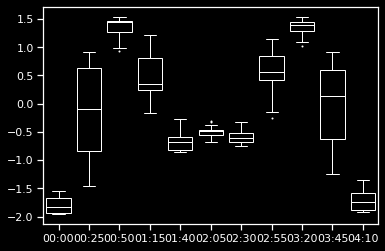

In [ ]:
#ESTE eh o mesmo tamanho que usaram no plotting time papper
figF, axF = plt.subplots(figsize=(6,4))
# remove grid
axF.grid(False)

axF.tick_params(axis='x', colors='1') 
axF.tick_params(axis='y', colors='1') 


axF.spines['left'].set_color('1')       
axF.spines['right'].set_color('1') 
axF.spines['bottom'].set_color('1') 
axF.spines['top'].set_color('1') 

#axF.axis('off')

sea.boxplot(index25sec, arrowSeries, ax=axF, linewidth='1', flierprops=flierprops, **PROPS)

In [ ]:
imageArray = fig2data(figF)

displayImageUniqueValues(imageArray)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


SHAPE:  (432, 288, 4) 

VALUES OF BACKGROUND: [  0   0   0 255] 

UNIQUE VALUES ON DATA: [  0   1   2   4   6   7   8   9  10  11  12  13  14  15  17  18  19  20
  21  22  23  24  25  26  28  30  31  32  33  34  35  36  37  38  39  40
  41  42  43  47  48  49  50  51  52  53  54  56  58  59  60  61  62  63
  67  68  69  71  73  74  75  76  77  78  80  82  83  84  85  87  88  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 106 107 109 113 114
 115 116 117 119 124 125 126 127 129 130 132 133 136 138 139 140 141 145
 146 147 148 149 150 154 155 156 159 160 161 168 170 171 172 173 174 175
 177 178 179 180 181 182 184 185 187 188 189 190 191 192 193 194 196 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 215 216 217
 219 220 221 222 223 225 226 227 228 229 231 232 233 234 235 236 237 238
 239 240 241 242 244 245 246 248 249 251 255]


In [ ]:
type(imageArray[0][0][0])

numpy.uint8

In [ ]:
#remove alpha (last channel 255)
#image_without_alpha = imageArray[:,:,:3]

#remove shades of grey
imageArrayF = pureBlackAndWhiteImageArray(imageArray)

displayImageUniqueValuesMore(imageArrayF)

ImageArray Shape: (432, 288, 4)
ImageReshape Shape: (124416, 4)
Shape of array (2, 4)
how many pixels: 2 or 2
Value:  [  0   0   0 255] | Occurrences: 485094
Value:  [255 255 255 255] | Occurrences: 136986


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  if __name__ == '__main__':


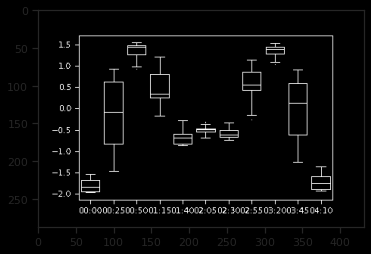

In [ ]:
image = array2img(imageArrayF)

plt.imshow(image)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

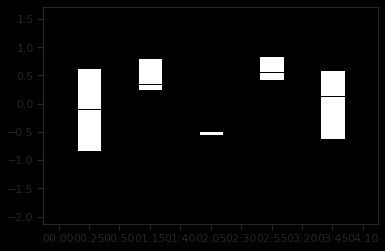

In [ ]:
figT, axT = plt.subplots(figsize=(6,4))
# remove grid
axT.grid(False)

colors = ["#000000", "#FFFFFF"]
sea.set_palette(sea.color_palette(colors))
sea.boxplot(index25sec, arrowSeries, ax=axT, linewidth='1', palette=sea.color_palette(colors))

In [ ]:
imageArrayT = fig2data(figT)

displayImageUniqueValues(imageArrayT)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


SHAPE:  (432, 288, 4) 

VALUES OF BACKGROUND: [  0   0   0 255] 

UNIQUE VALUES ON DATA: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38 255]


#BREAKKKK!!!!!!!!! Another tutorial github

In [ ]:
##@title Load packages and data
import os
import sys
import time
import copy
import random
import torch as th
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import matplotlib.cm as cm
import torch.nn.init as init
import matplotlib.pyplot as plt

from google.colab import drive
from itertools import product
from matplotlib.colors import Normalize
from sklearn.decomposition import PCA
from IPython.display import clear_output
from sklearn.metrics import accuracy_score, confusion_matrix
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler, StandardScaler

drive.mount('/content/drive')

path = 'INSERT YOUR PATH HERE'

def to_np(x):
    return x.cpu().detach().numpy()

The following cell defines a function that loads data in the .arff format. The function is based on the same function from the sktime libray found at [this website](https://github.com/alan-turing-institute/sktime).

In [ ]:
##@title Function for loading data in arff format. Code adopted from sktime library


def load_from_arff_to_dataframe(full_file_path_and_name, has_class_labels=True, return_separate_X_and_y=True, replace_missing_vals_with='NaN'):

    instance_list = []
    class_val_list = []

    data_started = False
    is_multi_variate = False
    is_first_case = True

    with open(full_file_path_and_name, 'r') as f:
        for line in f:

            if line.strip():
                if is_multi_variate is False and "@attribute" in line.lower() and "relational" in line.lower():
                    is_multi_variate = True

                if "@data" in line.lower():
                    data_started = True
                    continue

                # if the 'data tag has been found, the header information has been cleared and now data can be loaded
                if data_started:
                    line = line.replace("?", replace_missing_vals_with)

                    if is_multi_variate:
                        if has_class_labels:
                            line, class_val = line.split("',")
                            class_val_list.append(class_val.strip())
                        dimensions = line.split("\\n")
                        dimensions[0] = dimensions[0].replace("'", "")

                        if is_first_case:
                            for d in range(len(dimensions)):
                                instance_list.append([])
                            is_first_case = False

                        for dim in range(len(dimensions)):
                            instance_list[dim].append(pd.Series([float(i) for i in dimensions[dim].split(",")]))

                    else:
                        if is_first_case:
                            instance_list.append([])
                            is_first_case = False

                        line_parts = line.split(",")
                        if has_class_labels:
                            instance_list[0].append(pd.Series([float(i) for i in line_parts[:len(line_parts)-1]]))
                            class_val_list.append(line_parts[-1].strip())
                        else:
                            instance_list[0].append(pd.Series([float(i) for i in line_parts[:len(line_parts)]]))

    x_data = pd.DataFrame(dtype=np.float32)
    for dim in range(len(instance_list)):
        x_data['dim_' + str(dim)] = instance_list[dim]

    if has_class_labels:
        if return_separate_X_and_y:
            return x_data, np.asarray(class_val_list)
        else:
            x_data['class_vals'] = pd.Series(class_val_list)

    return x_data

In [ ]:
#@title Dataset loader and create dataset
def load_dataset(split, path, return_X_y=True):

    if split in ["TRAIN", "TEST"]:
        fname = 'ECG200_' + split + '.arff'
        abspath = os.path.join(path, fname)
        X, y = load_from_arff_to_dataframe(abspath)

    y = LabelBinarizer().fit_transform(y)
    if y.shape[1] == 1: y = np.hstack((y, 1 - y))

    X = pd.DataFrame(X).to_numpy()
    y = pd.DataFrame(y).to_numpy()

    X = np.array(np.ndarray.tolist(X), dtype=np.float32)
    y = np.array(np.ndarray.tolist(y), dtype=np.int32)

    where_are_NaNs = np.isnan(X)
    X[where_are_NaNs] = 0

    scaler = StandardScaler()

    for i in range(X.shape[1]):
        X[:, i, :] = scaler.fit_transform(X[:, i, :])

    # Return appropriately
    if return_X_y:
        return X, y
    else:
        X['class_val'] = pd.Series(y)
        return X

class TSDatasetSupervised(Dataset):
    def __init__(self, split, device='cuda'):

        self.device = device

        x, y = load_dataset(split=split, path=path, return_X_y=True)

        self.x = th.tensor(x, dtype=th.float, device=device)
        self.y = th.tensor(y, dtype=th.long, device=device).argmax(1)
        self.n_c = 2

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):      
        return self.x[idx], self.y[idx]

The following cell creates the class for the convolutional neural network used in this experiment. The model is based on the fully convolutional network of Want et.al.: [Time Series Classification from Scratch with Deep Neural Networks: A Strong Baseline](https://arxiv.org/abs/1611.06455).



In [ ]:
#@title Define CNN

class CNN(nn.Module):
    def __init__(self, n_in, n_c):
        super(CNN, self).__init__()

        n_hid = 128
        act = nn.ReLU()

        self.l1 = nn.Sequential(
            nn.Conv1d(n_in, n_hid, kernel_size=7, padding=3),
            nn.BatchNorm1d(n_hid),
            act
        )

        self.l2 = nn.Sequential(
            nn.Conv1d(n_hid, 2*n_hid, kernel_size=5, padding=2),
            nn.BatchNorm1d(2*n_hid),
            act
        )

        self.l3 = nn.Sequential(
            nn.Conv1d(2*n_hid, n_hid, kernel_size=3, padding=1),
            nn.BatchNorm1d(n_hid),
            act
        )

        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten()
        )

        self.out = nn.Linear(n_hid, n_c)

    def forward(self, x):

        l1 = self.l1(x)
        l2 = self.l2(l1)
        l3 = self.l3(l2)

        gap = self.gap(l3)
        out = self.out(gap)

        return out

    def CAM(self, x):
 
        l1 = self.l1(x)
        l2 = self.l2(l1)
        l3 = self.l3(l2)

        out = th.matmul(l3.transpose(2, 1), self.out.weight.T)
        out = nn.functional.relu(out)
        out = out.cpu().detach().numpy()

        return out



The following cell creates function that are used throughout the rest of the code.

In [ ]:
#@title Define some useful functions

def calc_metrics(y, y_hat):

    TN, FP, FN, TP = confusion_matrix(y, y_hat).ravel()

    precision = TP / (TP+FP)
    FallOut = FP / (FP+TN)
    recall = TP / (TP+FN)
    NPV = TN / (TN+FN)

    return [precision, recall, NPV, FallOut]


def get_ensemble_pred(x, model_list):

    for model_idx, model in enumerate(model_list):
        out = model(xte)
        if model_idx == 0: y_hat = to_np(th.nn.functional.softmax(out, dim=1))
        else: y_hat += to_np(th.nn.functional.softmax(out, dim=1))

    y_hat = y_hat / len(model_list)

    return y_hat

The following cell traings the single model and the ensemble model. In this code, "M" denotes the number of models in the ensemble, and "num_repeats" denotes the number of times the experiments will be repeated. This is set to 1 here, but in the paper we do 10 independet training runs.



In [ ]:
#@title Experiment

metrics_list = []
ensemble_metrics_list = []

M, num_repeats = 10, 1
model_list = []


training_set = TSDatasetSupervised('TRAIN')
test_set = TSDatasetSupervised('TEST')

batch_size_tr = len(training_set.x)
batch_size_te = len(test_set.x)

training_generator = DataLoader(training_set, batch_size=batch_size_tr,
                                shuffle=True, drop_last=False)
test_generator = DataLoader(test_set, batch_size= batch_size_te,
                                shuffle=True, drop_last=False)

for run in range(num_repeats):
    for m in range(M):

        print(f"Model number {m}")

        model = CNN(training_set.x.shape[1], training_set.n_c).to('cuda')
        criterion = th.nn.CrossEntropyLoss()
        optimizer = th.optim.Adam(model.parameters())

        LossList, AccList, epochs = [], [], 150

        for i in range(epochs):
            for xtr, ytr in training_generator:

                model.train()
                optimizer.zero_grad()

                xtr = xtr.to('cuda')
                out = model(xtr)

                loss = criterion(out, ytr)
                loss.backward()
                LossList.append(loss.item())
                optimizer.step()

            with th.no_grad():
                model.eval()
                for xte, yte in test_generator:

                    out = model(xte)
                    y_hat = th.argmax(out, 1)
                    accuracy = th.eq(yte, y_hat).sum().float() / len(xte)
                    AccList.append(accuracy.item())

        model_list.append(copy.deepcopy(model))
        metrics_list.append(calc_metrics(to_np(yte), to_np(y_hat)))
        print(metrics_list[-1])

    y_hat_ensemble = get_ensemble_pred(xte, model_list)
    ensemble_metrics_list.append(calc_metrics(to_np(yte), y_hat_ensemble.argmax(1)))
    print(ensemble_metrics_list[-1])


The following cell makes a prediction for a random sample in the test data and plots the time steps that are most relevant for the prediction, and the uncertainty of the relevance scores.



In [ ]:
#@title CAM illustration

model.eval()
N, T = test_set.x.shape[0], test_set.x.shape[-1]
sample = np.random.choice(list(np.arange(0, N, 1)), 1)[0]

my_cmap_mean = cm.get_cmap('Greens')
my_cmap_std = cm.get_cmap('Reds')
sm_mean = plt.cm.ScalarMappable(cmap=my_cmap_mean, norm=Normalize(vmin=0, vmax=1))
sm_std = plt.cm.ScalarMappable(cmap=my_cmap_std, norm=Normalize(vmin=0, vmax=1))

x_plot = np.arange(0, T, 1)

interpret_array =  np.array([model.CAM(test_set.x) for model in model_list])
interpret_array = interpret_array / (interpret_array.max(1, keepdims=True)+1.e-8)

interpret_mean = interpret_array.mean(0)
interpret_std = interpret_array.std(0)

pred = get_ensemble_pred(test_set.x, model_list).argmax(1)
y_samp = to_np(test_set.y[sample])
pred_samp = pred[sample]

scale_col_mean = np.abs(interpret_mean[sample, :, pred_samp] / (np.abs(interpret_mean[sample, :, pred_samp]).max())).reshape(T, 1)
color_weight_mean = np.ones((T, 3))
color_weight_mean = np.concatenate((color_weight_mean, scale_col_mean), 1)
plot_col_mean = my_cmap_mean(interpret_mean[sample, :, pred_samp])*color_weight_mean

plt.figure(1, figsize=(15, 5))
plt.plot(x_plot, to_np(test_set.x[sample])[0], color='black')
plt.bar(x_plot, 200*np.ones_like(x_plot), bottom=-100, width=1.0,
        color=plot_col_mean)
plt.xlim(0, T)
plt.ylim(to_np(test_set.x[sample])[0].min(), to_np(test_set.x[sample])[0].max())
plt.title(f"Mean relevance score. True: {y_samp}. Predicted: {pred_samp}")
plt.ylabel('mV')
plt.xlabel('ms')
plt.show()

scale_col_std = np.abs(interpret_std[sample, :, pred_samp] / (np.abs(interpret_std[sample, :, pred_samp]).max())).reshape(T, 1)
color_weight_std = np.ones((T, 3))
color_weight_std = np.concatenate((color_weight_std, scale_col_std), 1)
plot_col_std = my_cmap_std(interpret_std[sample, :, pred_samp])*color_weight_std

plt.figure(2, figsize=(15, 5))
plt.plot(x_plot, to_np(test_set.x[sample])[0], color='black')
plt.bar(x_plot, 200*np.ones_like(x_plot), bottom=-100, width=1.0,
        color=plot_col_std)
plt.xlim(0, T)
plt.ylim(to_np(test_set.x[sample])[0].min(), to_np(test_set.x[sample])[0].max())
plt.title(f"Uncertainty of relevance score. True: {y_samp}. Predicted: {pred_samp}")
plt.ylabel('mV')
plt.xlabel('ms')
plt.show()

filtered_time_steps = (scale_col_std.squeeze() < scale_col_std.squeeze().mean())*1.0
scale_col_filtered = np.reshape(scale_col_mean.squeeze() * filtered_time_steps, (T, 1))
color_weight_filtered = np.ones((T, 3))
color_weight_filtered = np.concatenate((color_weight_filtered, scale_col_filtered), 1)
plot_col_filtered = my_cmap_mean(interpret_mean[sample, :, pred_samp])*color_weight_filtered


plt.figure(3, figsize=(15, 5))
plt.plot(x_plot, to_np(test_set.x[sample])[0], color='black')
plt.bar(x_plot, 200*np.ones_like(x_plot), bottom=-100, width=1.0,
        color=plot_col_filtered)
plt.xlim(0, T)
plt.ylim(to_np(test_set.x[sample])[0].min(), to_np(test_set.x[sample])[0].max())
plt.ylabel('mV')
plt.xlabel('ms')
plt.title(f"Uncertainty-filtered mean relevance score. True: {y_samp}. Predicted: {pred_samp}")
plt.show()

The following cell computes the consistency for single and ensemble model. This cell takes some time to run.

In [ ]:
#@title Compute consistency over independent training runs


num_repeats, M = 10, 10
topk_list = [5, 7, 10, 15]

training_set = TSDatasetSupervised('TRAIN')
test_set = TSDatasetSupervised('TEST')

batch_size_tr = len(training_set.x)
batch_size_te = len(test_set.x)

training_generator = DataLoader(training_set, batch_size=batch_size_tr,
                                shuffle=True, drop_last=False)
test_generator = DataLoader(test_set, batch_size= batch_size_te,
                                shuffle=True, drop_last=False)

single_model_rel_scores = np.zeros((num_repeats, 100, test_set.x.shape[-1]))
ensemble_model_rel_scores = np.zeros((num_repeats, 100, test_set.x.shape[-1]))

for repeat_n in range(num_repeats):

    model_list = []

    print(f"Run number {repeat_n}")

    for m in range(M):

        print(f"Model number {m}")

        model = CNN(training_set.x.shape[1], training_set.n_c).to('cuda')
        criterion = th.nn.CrossEntropyLoss()
        optimizer = th.optim.Adam(model.parameters())

        LossList, AccList, epochs = [], [], 150

        for i in range(epochs):
            for xtr, ytr in training_generator:

                model.train()
                optimizer.zero_grad()

                xtr = xtr.to('cuda')
                out = model(xtr)

                loss = criterion(out, ytr)
                loss.backward()
                LossList.append(loss.item())
                optimizer.step()

            with th.no_grad():
                model.eval()
                for xte, yte in test_generator:

                    out = model(xte)
                    y_hat = th.argmax(out, 1)
                    accuracy = th.eq(yte, y_hat).sum().float() / len(xte)
                    AccList.append(accuracy.item())

        model_list.append(copy.deepcopy(model))

    interpret_array = model_list[np.random.randint(0, len(model_list), 1)[0]].CAM(test_set.x)
    single_model_rel_scores[repeat_n] = np.take_along_axis(interpret_array,
                                                           to_np(test_set.y[:, None, None]), axis=2).squeeze()


    interpret_array_ensemble = np.array([model.CAM(test_set.x) for model in model_list])
    interpret_array_ensemble = interpret_array_ensemble.mean(0)

    ensemble_model_rel_scores[repeat_n] = np.take_along_axis(interpret_array_ensemble,
                                                             to_np(test_set.y[:, None, None]), axis=2).squeeze()

    clear_output()

for topk_idx, topk in enumerate(topk_list):

    interpret_idx = single_model_rel_scores.argsort(2)[:, :, -topk:]
    sim_array = np.zeros((num_repeats, num_repeats))

    for i in range(num_repeats):
        for j in range(num_repeats):
            sim_array[i, j] = sum([np.isin(interpret_idx[i, n], interpret_idx[j, n]).sum() / topk for n in range(len(test_set.x))]) / len(test_set.x)

    print(f"Consistency for single model: {sim_array.mean()}")

for topk_idx, topk in enumerate(topk_list):

    interpret_idx = ensemble_model_rel_scores.argsort(2)[:, :, -topk:]
    sim_array = np.zeros((num_repeats, num_repeats))

    for i in range(num_repeats):
        for j in range(num_repeats):
            sim_array[i, j] = sum([np.isin(interpret_idx[i, n], interpret_idx[j, n]).sum() / topk for n in range(len(test_set.x))]) / len(test_set.x)

    print(f"Consistency for ensemble model: {sim_array.mean()}")

# New results from time series archive (UCR)

In [ ]:
!pip install pyts

     |████████████████████████████████| 2.5 MB 4.8 MB/s 


## Algorithms

*   S-BOSS
*   cBOSS (ContractableBOSS)
*   BOSS
*   STC



Resultados no Excel que temos, nãao são os mesmos que são apresentados ns papers referentes, e no site oficial do BOSS:
https://www2.informatik.hu-berlin.de/~schaefpa/boss/
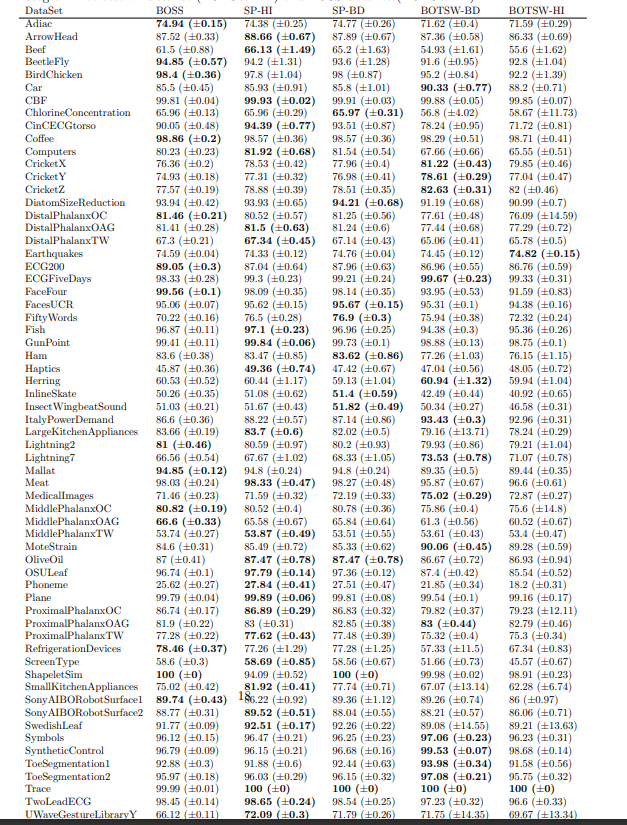

In [ ]:
import pandas as pd
import numpy as np
from scipy.io import arff
from sklearn.preprocessing import LabelEncoder


def load_arff_file(path):
    data = arff.loadarff(path)
    return pd.DataFrame(data[0])

def load_data(df, target):
    X = df.drop(columns=[target]).values
    y = df[target].values
    return X, y

def encode_data(df, encoder=None, target='target'):
    if encoder == None:
        encoder = LabelEncoder()
        encoder.fit(df[target])
    df[target] = encoder.transform(df[target])
    return encoder, df

def decode_data(df, encoder, target='target'):
    df[target] = encoder.inverse_transform(df[target])
    return df

## Test some old algorithms sktime


In [ ]:
hc2 = HIVECOTEV2(time_limit_in_minutes=1)
hc2.fit(arrow_train_X, arrow_train_y)
y_pred = hc2.predict(arrow_test_X)
accuracy_score(arrow_test_y, y_pred)

In [ ]:
clf = BOSSEnsemble()
clf.fit(train_x, train_y)
y_pred = clf.predict(test_x)
accuracy_score(test_y, y_pred)

0.84

In [ ]:
clf = IndividualBOSS()
clf.fit(train_x, train_y)
y_pred = clf.predict(test_x)
accuracy_score(test_y, y_pred)

0.5142857142857142

In [ ]:
#clf = ContractableBOSS(n_parameter_samples=25, max_ensemble_size=5)
clf = ContractableBOSS()
clf.fit(train_x, train_y)
y_pred = clf.predict(test_x)
accuracy_score(test_y, y_pred)

0.8628571428571429

In [ ]:
rocket = RocketClassifier()
rocket.fit(arrow_train_X, arrow_train_y)
y_pred = rocket.predict(arrow_test_X)
accuracy_score(arrow_test_y, y_pred)

In [ ]:
classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(arrow_train_X, arrow_train_y)
y_pred = classifier.predict(arrow_test_X)
accuracy_score(arrow_test_y, y_pred)

In [ ]:
tsfresh = TSFreshFeatureExtractor(default_fc_parameters="minimal")
randf = RandomForestClassifier(n_estimators=100)
pipe = Pipeline(
    [
        ("transform", tsfresh),
        ("classifier", randf),
    ]
)
pipe.fit(arrow_train_X, arrow_train_y)
y_pred = pipe.predict(arrow_test_X)
accuracy_score(arrow_test_y, y_pred)

# LOOP for google colab

In [ ]:
from time import time, sleep
count = 0
while True:
    count = count + 1
    sleep(60 - time() % 60)
    print("Conta: ", 60 - time() % 60, " minuto: ", count)

Conta:  59.9927659034729  minuto:  1
Conta:  59.95704913139343  minuto:  2
Conta:  59.962602376937866  minuto:  3
Conta:  59.94787645339966  minuto:  4
Conta:  59.990150451660156  minuto:  5
Conta:  59.96071910858154  minuto:  6
Conta:  59.96138095855713  minuto:  7
Conta:  59.93999767303467  minuto:  8
Conta:  59.951926708221436  minuto:  9
Conta:  59.99859166145325  minuto:  10
Conta:  59.967617988586426  minuto:  11
Conta:  59.951353549957275  minuto:  12
Conta:  59.97762870788574  minuto:  13
Conta:  59.967365980148315  minuto:  14
Conta:  59.94696521759033  minuto:  15
Conta:  59.978063344955444  minuto:  16
Conta:  59.982369899749756  minuto:  17
Conta:  59.95991778373718  minuto:  18
Conta:  59.96699094772339  minuto:  19
Conta:  59.939976930618286  minuto:  20
Conta:  59.96695113182068  minuto:  21
Conta:  59.96077346801758  minuto:  22
Conta:  59.9927659034729  minuto:  23
Conta:  59.96078968048096  minuto:  24
Conta:  59.952250719070435  minuto:  25
Conta:  59.96020579338074 

KeyboardInterrupt: ignored

In [ ]:
!nvidia-smi
!kill process_id

#Notes

**Dense/fully connected layer:** A linear operation on the layer’s input vector.

**Convolutional layer:** A layer that consists of a set of “filters”. The filters take a subset of the input data at a time, but are applied across the full input (by sweeping over the input). The operations performed by this layer are still linear/matrix multiplications, but they go through an activation function at the output, which is usually a non-linear operation.

**Pooling layer:** We utilise the fact that consecutive layers of the network are activated by “higher” or more complex features that are exhibited by a larger area of the networks input data. A pooling layer effectively down samples the output of the prior layer, reducing the number of operations required for all the following layers, but still passing on the valid information from the previous layer.

**Normalisation layer:** Used at the input for feature scaling, and in batch normalisation at hidden layers.

# Next to do

ANALISAR o que acontece nos datasets com pouca length e boxplots parecem "não ter dados". Tentar perceber o que se passa na funçãao geral

VER QUAL usar. KERAS ou Pytorch. Ver ao dar save e load das imagens. e como treina os modelos.
Criar funçãao automatica para "melhor numero de boxplots" para cada dataset

* **DONE** Falta generalizar a função de conversão para boxplot. A parte de converter para Series com um certo index. ver o que aconteceu com o novo dataset
* **DIFICULDADES** Tentar gravar a imagem só com um channel. Testar com PIL. Ver se quando gravo a imagem ele não aplica um greyscale sobre o greyscale
* Depois de conseguir converter, ver se existe diferença entre o greyscale e pure black para o novo dataset
* Dar plot ao test
* **DONE** Posso remover o one-hot-enconding e usar o spart-categorical no compile do modelo VER
* Criar a nova implementação para violin plots.
* Visto que nãao consigo guardar os dados em arrays devido ao tempo que demora, tentar guardar em imagens... tenho que arranjar uma maneira boa de guardar e obter dados. VALIDAR
* Perceber qual é a melhor CNN a usar
---
* Remover os fliers do boxplots e testar
* Ver violin plots com None e com Box lá dentro
* Expermentar violin plots
* Expermentar boxplots com cores
* Ver código e testar do CPC-R e DeepInsight
---
* Arranjar algo para os multivariados
* Talvez melhorar a forma de cálculo do index. Atualmente faz um round da divisão do número de boxplots. Mas isto pode fazer com que o último boxplot não fique com dados suficientes

Guardar em imagens em pastas:
* TRAIN
  * Class a
    * imagem1
    * imagem2
  * Class b
    * imagem1
    * imagem2
* TEST
  * Class a
    * imagem1
    * imagem2
  * Class b
    * imagem1
    * imagem2
